<a href="https://colab.research.google.com/github/LokeshDamarla/AI/blob/main/PVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.3 MB/s eta 0:00:00


In [2]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.8 MB/s eta 0:00:00


In [152]:
import wfdb
from copy import deepcopy
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import csv
from keras import backend as K
from scipy.stats import skew
from keras.models import load_model
from scipy.signal import find_peaks
from tensorflow.keras import backend as K
from sklearn.ensemble import RandomForestClassifier
import pickle
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,BatchNormalization,Activation,Lambda,concatenate
from statsmodels.tsa.stattools import acf

# **De-Noise**

In [9]:
signal_I01_peaks = pd.read_csv('/content/drive/MyDrive/ECG/incart_DB/Incart_csv/I01.csv')

In [83]:
from biosppy.signals import ecg

# Access the 'II' column (assuming it contains the ECG signal data for Lead II)
ii_data = ecg_clean

# Process the ECG signal using biosppy
out = ecg.ecg(ii_data, sampling_rate=1000, show=False)

# Get the R-peak locations
r_peaks = out['rpeaks']

# Print the R-peak locations
print("R-peak locations:")
print(r_peaks)



R-peak locations:
[   279    634    907   1168   1434   1721   1983   2396   3099   3380
   3678   3963   4484   5314   6396   6837   7323   7644   8126   8592
   9235   9889  10483  10795  12054  12368  12674  13453  13921  14079
  14701  15174  15643  16104  16427  16899  17379  17866  18180  18985
  19787  20255  20723  21285  21683  22325  22838  23153  23507  24157
  24339  24825  25190  25716  26216  26406  26744  27061  27254  27594
  27915  28115  28465  28789  29163  29852  30054  30744  31599  31758
  32298  32819  33494  33856  34364  35066  35431  36339  36850  37047
  37551  37754  38087  38290  38798  39007  39345  39556  40072  40627
  41178  41379  41893  42098  42437  42814  43142  43345  43850  44052
  44550  44923  45254  45452  45962  46353  46688  46889  47398  47931
  48305  48997  49368  49534  50068  50498  50770  51302  51671  52028
  52377  53080  53613  54144  54336  54682  55370  55909  56440  56747
  57103  57627  57979  58502  59009  59214  59555  59750  6

In [84]:
type(r_peaks)

numpy.ndarray

In [13]:
signal_I01 = pd.read_csv('/content/drive/MyDrive/ECG/incart_DB/Incart_csv/I01.csv')

In [14]:
signal_I01 = signal_I01.to_numpy()

In [15]:
signal_I01.shape

(462600, 1)

In [16]:
signal_I01 = signal_I01.reshape((signal_I01.shape[0],))

In [22]:
signal_I01.shape

(462600,)

In [85]:
r_peaks.shape

(976,)

In [86]:
def swt1d(signal,N,mwvlt):

    sig_len = len(signal)
    signal = signal/max(signal);

    signal_pad = power2pad(signal,N) # pad with zeros to make length as power of 2
    pywvlt = pywt.Wavelet(mwvlt) # create PyWavelet object
    swt_res = pywt.swt(signal_pad,pywvlt,N) # call Pywavelet's SWT

    swa = np.zeros((N,sig_len))
    swd = np.zeros((N,sig_len))

    for i in range(N):
        swa_temp = swt_res[N-i-1][0]
        swa[i] = swa_temp[:sig_len]

        swd_temp = swt_res[N-i-1][1]
        swd[i] = swd_temp[:sig_len]

    return swa,swd

In [87]:
def iswt1d(swa,swd,mwvlt):

    n1 = swa.shape[0]
    n2 = swd.shape[0]

    if(n1 != n2):
        error('SWA and SWD have different scales')

    N = n1
    pywvlt = pywt.Wavelet(mwvlt) # create PyWavelet object

    iswt_list = list()

    for i in range(N):

        swa_temp = power2pad(swa[N-i-1],N)

        swd_temp = power2pad(swd[N-i-1],N)
        swt_temp = list((swa_temp,swd_temp))
        iswt_list.append(swt_temp)


    iswt_res = pywt.iswt(iswt_list,pywvlt) # call Pywavelet's ISWT

    return iswt_res

In [88]:
def power2pad(signal_act, def_N=11):

    signal_pad = deepcopy(signal_act);
    sig_len = signal_pad.shape[0]

    N = int(np.log2(sig_len))

    if(N < def_N):
        zero_len = np.power(2,def_N) - sig_len

        signal_pad = np.pad(signal_pad,pad_width=((0,zero_len)),mode='constant')
    else:
        zero_len = np.power(2,(N+1)) - sig_len

        if(zero_len >= 1):
            signal_pad = np.pad(signal_pad,pad_width=((0,zero_len)),mode='constant')

    return signal_pad

In [89]:
def plot_fft(x,Fs,sc=0):

    xfft = np.fft.fft(x);
    xfft_abs = abs(xfft);

    if(sc):
        xfft_abs = xfft_abs/(max(xfft_abs));

    t = np.arange(len(x))/Fs;

    no_samples = t.shape[0];
    div = no_samples/Fs;

    freq = np.arange(0,len(x)/(2*div),step=1/div);

    xfft_abs = xfft_abs[1:int(len(x)/2)+1];

    return xfft_abs,freq[:xfft_abs.shape[0]]

In [90]:
def scale_nonmax(ecg_seg,Fs):

    seg_locs,_ = find_peaks(abs(ecg_seg),distance=np.ceil(0.25*Fs))

    if not seg_locs.shape[0]:
        ecg_sc =  ecg_seg/max(abs(ecg_seg))
        return ecg_sc

    seg_pks = abs(ecg_seg[seg_locs])
    seg_pks_sort = np.sort(seg_pks)

    if(seg_pks_sort.shape[0] < 10):
        seg_pks_sort10 = seg_pks_sort
    else:
        seg_pks_sort10 = seg_pks_sort[-10:]

    sc_fctr = np.median(seg_pks_sort10)

    ecg_sc = ecg_seg/sc_fctr

    return ecg_sc

In [91]:
def get_ecgwin(ecg,win,Fs,sc=0):

    ecg_len = ecg.shape[0]

    no_win = int(ecg_len/win)

    ecg_win = np.zeros((no_win,int(win)))

    for k in range(no_win):

        st = int(k*win)
        fi = int((k+1)*win)

        temp = deepcopy(ecg[st:fi])
        if sc:
            if(sc == 1):
                temp = temp/max(abs(temp))
            else:
                temp = scale_nonmax(temp,Fs)

        ecg_win[k,:] = temp

    return ecg_win

In [92]:
def clean_ecg_swt(ecg,modify=False,emswd=False):

    Fs = 360
    ecg_len = len(ecg)

    N = 9  # SWT levels
    mwvlt = 'db3'  # Daubechies3 mother wavelet
    _,swd = swt1d(ecg,N,mwvlt)

    swd2 = deepcopy(swd)

    ## swd[4,...] actually refers to level-5 coefficients
    ## swd[3,...] refers to level-4 coefficients

    swd4 = deepcopy(swd[3,:ecg_len])

    # Minimize false beat detection (unusually large tT-waves in particular) by minimizing effect of level-5 coefficients
    if(modify):

        c = deepcopy(swd[4,:])
        e = c*np.abs(c)

        len_seg = 10*Fs

        for i in range(0,ecg_len,len_seg):

            fi = np.min((i+len_seg,ecg_len))
            temp_e = e[i:fi]
            temp_s = swd[4,i:fi]

            e[i:fi] = temp_e/np.max(np.abs(temp_e))*np.max(np.abs(temp_s))

        swd[4,:] = e

    swd1 = deepcopy(swd)

    # Nullify detail coefficients corresponding to frequencies lower than 0.7Hz
    if(N > 7):
        swd1[8:,:] = 0

    # Reconstruct the baseline wander removed signal
    swa1 = np.zeros((N,ecg_len))
    recons = iswt1d(swa1,swd1,mwvlt)
    recons = recons*np.max(ecg)

    ecg_bw_rem = recons[:ecg_len]

    # Reconstruct anouther signal wiht only SWT level 6 and 7 coefficients to be used in EM noise analysis
    if not emswd:
        swd67 = np.zeros(ecg_len)
    else:
        swd2[:5,:] = 0
        swd2[7:,:] = 0
        swa2 = np.zeros((N,ecg_len))
        swd67 = iswt1d(swa2,swd2,mwvlt)
        swd67 = swd67[:ecg_len]

    return ecg_bw_rem,swd4,swd67

In [93]:
def cae_denoise(ecg,modify=False,emswd=False):

    Fs = 360 # sampling frequency
    den_inputlen = 232
    trunc_len = 5
    act_len = ecg.shape[0] # actual length of input ECG

    # Baseline wander (BW) removal using SWT
    ecg_bw_rem,swd4,swd67 = clean_ecg_swt(ecg,modify,emswd)

    # Scale the BW-removed signal in blocks of 10s
    sc_win = 10*Fs
    ecg_wintemp = get_ecgwin(ecg_bw_rem,sc_win,Fs,2)
    no_10s = ecg_wintemp.shape[0]
    len_ecg = len(ecg_bw_rem)
    tot_10s = no_10s*sc_win

    ecg1 = np.array([])

    for i1 in range(no_10s):
        ecg_seg = deepcopy(ecg_wintemp[i1,:])
        ecg1 = np.append(ecg1,(modify+1)*ecg_seg,axis = 0)

    if(len_ecg > tot_10s):

        ecg_seg = deepcopy(ecg_bw_rem[tot_10s:len_ecg])
        ecg_seg = scale_nonmax(ecg_seg,Fs)

        ecg1 = np.append(ecg1,(modify+1)*ecg_seg,axis = 0)

    # Copy the scaled signal to another variable and append zeros at the end
    hp_filt = deepcopy(ecg1)
    hp_filt = np.append(hp_filt,np.zeros(den_inputlen),axis=0)

    hp_len = hp_filt.shape[0]

    # Prepare data for removing high frequency noise using DCAE model.
    # This involves dividing the input into an array of shape (?,232) using a sliding window of 2*trunc_len

    m = 0

    temp1 = np.array([])

    while(m < hp_len):
        temp = deepcopy(hp_filt[m:min(hp_len,m+den_inputlen)])

        if(len(temp) < den_inputlen):
            temp = np.pad(temp,pad_width=(0,(den_inputlen-len(temp))),mode='constant')
            break

        if not m:
            temp1 = deepcopy(temp.reshape(1,den_inputlen))
        else:
            temp1 = np.append(temp1,temp.reshape(1,den_inputlen),axis = 0)

        m = m + den_inputlen-(2*trunc_len)


    temp1 = temp1.reshape(temp1.shape[0],temp1.shape[1],1)

    K.clear_session() # clear keras session

    # Load Denoising CAE model
    denoise_model = load_model('/content/drive/MyDrive/ECG/cae_denoise.h5')

    # Denoised output of shape (?,232)
    temp2 = denoise_model.predict(temp1)

    no_seg = temp2.shape[0]

    # Reshape the Mx232 back to a 1D-array
    # This is the final cleaned signal (BW + HF-noise removed)

    for i in range(no_seg):
        if not i:
            temp = temp2[i,:den_inputlen-trunc_len] # exclude last <trunc_len> samples

        else:
            if(i == (no_seg-1)):
                temp = temp2[i,trunc_len:]
            else:
                temp = temp2[i,trunc_len:den_inputlen-trunc_len] # exclude first and last <trunc_len> samples

        temp = temp[:,0]

        if not i:
            ecg_clean = temp
        else:
            ecg_clean = np.append(ecg_clean,temp,axis=0)

    ecg_clean = ecg_clean[:act_len]
    swd4 = swd4[:ecg_clean.shape[0]]

    return ecg_clean,swd4,swd67

In [94]:
# Denoised Function Call
ecg_clean,swd4,swd67 = cae_denoise(signal_I01,modify=False,emswd=False)

66/66 [==============================] - 1s 6ms/step


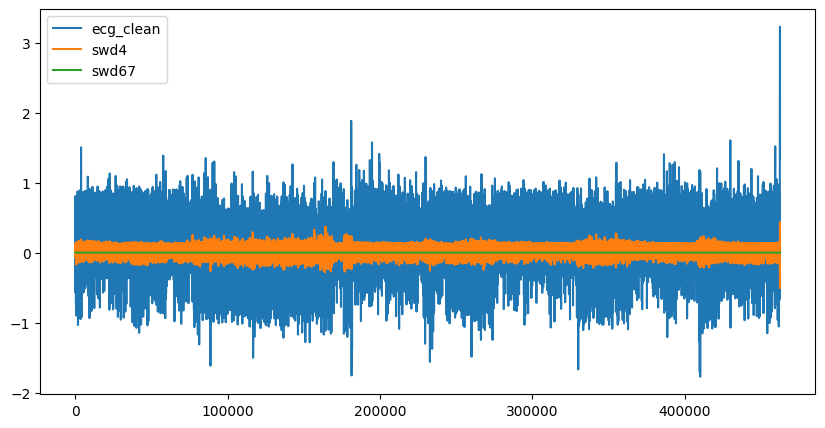

In [95]:
plt.figure(figsize=(10, 5))
clean_ecg_signal = ecg_clean
swd41 = swd4
plt.plot(clean_ecg_signal,label='ecg_clean')
plt.plot(swd41,label='swd4')
plt.plot(swd67,label='swd67')
plt.legend()
plt.show()

In [96]:
# Base Wander removel Function Call
bw_removed_signal,swd41,swd671 = clean_ecg_swt(signal_I01,modify=False,emswd=False)

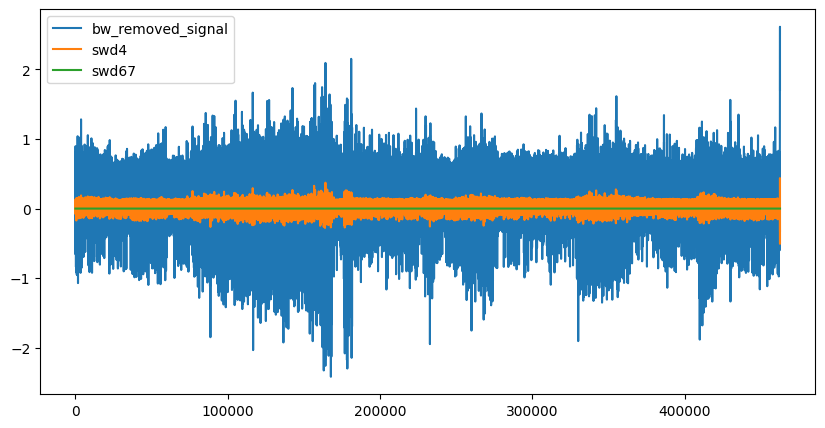

In [97]:
plt.figure(figsize=(10, 5))
bw_removed_signal = bw_removed_signal
swd42 = swd41
swd671 = swd67
plt.plot(bw_removed_signal,label='bw_removed_signal')
plt.plot(swd42,label='swd4')
plt.plot(swd671,label='swd67')
plt.legend()
plt.show()

In [98]:
ecg_clean

array([-0.01062253, -0.01779279, -0.01735074, ...,  2.1296186 ,
        1.6953319 ,  1.3519763 ], dtype=float32)

In [99]:
ecg_clean.shape

(462600,)

In [100]:
swd4.shape

(462600,)

In [101]:
swd67.shape

(462600,)

In [102]:
def em_noise(ecg,swd,vtvf_flag,swd67,ecg_orig,fs):

    Fs = 360
    win = 10*Fs

    # Prepare data for EM noise classification using CNN model
    ecg_win = get_ecgwin(ecg,win,Fs,1)
    ecg_orig_win = get_ecgwin(ecg_orig,10*fs,fs,1)
    swd_win = get_ecgwin(swd,win,Fs,1)
    swd67_win = get_ecgwin(swd67,win,Fs,1)

    ecg_win = ecg_win.reshape(ecg_win.shape[0],ecg_win.shape[1],1)
    swd_win = swd_win.reshape(swd_win.shape[0],swd_win.shape[1],1)
    ecg_inp = np.append(ecg_win,swd_win,axis = 2)

    K.clear_session()  # clear keras session

    # Load CNN model and predict
    em_model = load_model('em_noise_model_swd.h5')
    em_pred = em_model.predict(ecg_inp)
    em_pred = em_pred[:,1]
    em_ind = np.zeros(em_pred.shape[0])
    em_ind[np.where(em_pred >= 0.9)[0]] = 1

    em1 = np.where(em_ind == 1)[0]

    # Account for sustained VT/VF presence that was undetected by the VT/VF algorithm
    for i in em1:

        a = ecg_win[i,:,0]
        a = a/max(abs(a))
        b = swd67_win[i,:]
        b = b/max(abs(b))

        r = np.correlate(a,b,mode='full')
        if(max(r) > 400):
            em_ind[i] = 0

    em0 = np.where(em_ind == 0)[0]

    # Check for flatline artifacts
    for i in em0:

        a = ecg_orig_win[i,:]
        a_diff  = np.diff(a)

        [a_loc,a_len] = cu.getCons(a_diff,0,length=0.25*fs,exactly=0)

        if(a_loc.size):
            if(sum(a_len) > fs):
                em_ind[i] = 1
                continue

    if(em_ind.shape[0] < vtvf_flag.shape[0]):
        em_ind = np.append(em_ind,np.zeros(vtvf_flag.shape[0] - em_ind.shape[0]),axis = 0)

    # Remove EM noise classification for segments containing VT/VF episodes
    em_ind[np.where(vtvf_flag == 1)[0]] = 0

    # Compute EM noise episode onsets, offset and duration
    em_loc, em_len = cu.getCons(em_ind,1)

    em_arr = np.array([])
    dur_em = 0

    for i in range(em_loc.shape[0]):
        st_em = em_loc[i]*win
        fi_em = (em_loc[i] + em_len[i])*win
        st_fi = np.array([st_em,fi_em])
        st_fi = st_fi.reshape(1,st_fi.shape[0])

        if not em_arr.size:
            em_arr = st_fi
        else:
            em_arr = np.append(em_arr,st_fi,axis=0)

        dur_em += (fi_em - st_em) + 1

    return em_ind,em_arr,dur_em,em_pred

In [38]:
# EM Function call


In [103]:
def pvc_features(ecg,locs):

    Fs = 360 # default sampling frequency

    l_win = int(np.floor(0.25*Fs))
    r_win = int(np.ceil(0.40*Fs))

    l_win1 = int(np.floor(0.125*Fs))
    r_win1 = int(np.ceil(0.125*Fs))

    rr = np.append(0, np.diff(locs)) # RR-interval series
    sdrr = np.append(np.array([0, 0]), ((rr[2:] - rr[1:-1])/rr[1:-1])*100) # percentage change in successive difference of RR-intervals (SDRR)

    pvc_feat = np.array([])

    i = 1
    inv = []

    while i < (locs.shape[0]-1):

        locs_ind = int(locs[i])

        l_st = locs_ind - l_win
        r_fi = locs_ind + r_win + 1

        # Raw ECG beat segment (235 samples) --> segment P
        seg_P = ecg[l_st:r_fi]
        seg_P = seg_P/max(abs(seg_P))

        # ECG beat segment for manual extraction --> Segment Q
        seg_Q = ecg[locs_ind - l_win1:locs_ind + r_win1 - 1]

        if i < 2:
            seg_Q_old = deepcopy(seg_Q) # store beat template for next iteration

            i += 1
            continue

        # Feature 1: Heart rate
        hr = Fs*60/rr[i]

        # Feature 2: Percentage change in SDRR
        rr_diff = sdrr[i]

        # Feature 3: Pearson's Correlation coefficient between current beat segment and previous beat segment (segment Q)
        ccf = np.corrcoef(seg_Q_old,seg_Q)

        # Crosscorrelation between current beat segment and previous beat segment (segment Q)
        corrseq = np.correlate(seg_Q_old,seg_Q,'full')
        corrseq = corrseq/max(abs(corrseq))

        # Feature 4: Skewness of crosscorrelation
        skewval = skew(corrseq)

        if len(seg_P) < 235:
            seg_P = np.append(seg_P,np.zeros(235-len(seg_P)))
            inv.append(i)

        # Concatenate beat segment P with the four manually computed features
        seg_feat = np.append(seg_P,np.array([hr,rr_diff,ccf[0][1],skewval]),axis=0)

        # Check for NaNs and inifinity
        if True in np.isnan(seg_feat):
            seg_feat = np.zeros(239)
            inv.append(i)

        if True in np.isinf(seg_feat):
            seg_feat = np.zeros(239)
            inv.append(i)

        seg_feat = seg_feat.reshape(1,seg_feat.shape[0])

        # Update feature matrix
        if not pvc_feat.size:
            pvc_feat = seg_feat
        else:
            pvc_feat = np.append(pvc_feat,seg_feat,axis=0)

        i += 1
        seg_Q_old = deepcopy(seg_Q) # store beat template for next iteration

    return pvc_feat,inv

In [104]:
# PVC Features Function call
pvcfeat,invalid_beats =  pvc_features(ecg_clean,r_peaks)

In [105]:
pvcfeat.shape

(973, 239)

In [106]:
invalid_beats

[]

In [145]:
def create_ae_model(input_len_ae,input_len_clf,latent_dim,use_feat,activation_fn='relu'):

    # encoder
    input_layer_ae = Input(shape=(input_len_ae,),name='input_layer_ae')
    x = Dense(128,activation=activation_fn)(input_layer_ae)
    x = Dense(64,activation=activation_fn)(x)
    enc_vec = Dense(latent_dim,name='enc_emb')(x)

    enc = Model(input_layer_ae,enc_vec,name='ae_enc')

    # decoder
    latent_vars = Input(shape=(latent_dim,),name='enc_op')
    x = Dense(64,activation=activation_fn)(latent_vars)
    x = Dense(128,activation=activation_fn)(x)
    output_layer = Dense(input_len_ae,activation='tanh')(x)
    dec = Model(latent_vars,output_layer,name='ae_dec')
    output = dec(enc(input_layer_ae))

    # classifier
    if use_feat:
        input_layer_clf = Input(shape=(input_len_clf,),name='input_layer_clf')
        input_layer_enc = Input(shape=(latent_dim,),name='input_layer_enc')
        enc_vec_feat = concatenate([input_layer_clf,input_layer_enc])
        x_clf = Dense(5,activation='relu')(enc_vec_feat)
    else:
        input_layer_enc = Input(shape=(latent_dim,),name='input_layer_enc')
        x_clf = Dense(5,activation='relu')(input_layer_enc)

    x_clf = Dense(4,activation='relu')(x_clf)
    x_clf = Dense(3,activation='relu')(x_clf)
    x_clf = Dense(2,activation='softmax',name='classifier')(x_clf)

    if use_feat:
        clf = Model([input_layer_clf,input_layer_enc],x_clf,name='vae_feat_classifier')
        output_clf = clf([input_layer_clf,enc(input_layer_ae)])
        ae_model = Model(inputs = [input_layer_ae,input_layer_clf], outputs = [output,output_clf])
    else:
        clf = Model(input_layer_enc,x_clf,name='vae_feat_classifier')
        output_clf = clf(enc(input_layer_ae))
        ae_model = Model(inputs = input_layer_ae, outputs = [output,output_clf])

    return ae_model

In [146]:
# Create ae-model Function Call
raw_ecg_len = 235 # length of raw ECG
manual_feat = 4 # number of manual features
latent_dim = 3 # number of encodings
use_feat = 1
model_ae = create_ae_model(raw_ecg_len,manual_feat,latent_dim,use_feat)

In [148]:
type(model_ae)

keras.engine.functional.Functional

In [108]:
def beatClassify(ecg,loc,inv_beats,pvc_thr):
    K.clear_session() # clear keras session

    pvc_mdl3 = '/content/drive/MyDrive/ECG/pvc_3beats.h5' # 3-beat PVC detection model

    raw_ecg_len = 235 # length of raw ECG
    manual_feat = 4 # number of manual features
    latent_dim = 3 # number of encodings
    use_feat = 1

    # Create SSAE network
    ae_model = create_ae_model(raw_ecg_len,manual_feat,latent_dim,use_feat)

    # Load model weights for the SSAE network
    ae_model.load_weights(pvc_mdl3)
    full_model = Model(inputs=ae_model.inputs,outputs=ae_model.outputs[1])

    # Create a new model that extracts the encoding layer's output
    vae_enc = ae_model.get_layer('ae_enc')
    enc_model = Model(inputs = vae_enc.inputs, outputs = vae_enc.outputs)

    # Compute manual features that will be part of the SSAE network's input
    feat,inv = pvc_features(ecg,loc)

    # Extract two inputs for the SSAE network --> (i) Raw ECG and (ii) manual features
    x_raw = feat[:,:235]
    x_feat = feat[:,235:239]

    # Compute the 3-dimensional encodings and concatenate them with manual features
    z_val = enc_model.predict(x_raw)
    z_feat = np.c_[z_val,x_feat]

    # Load RF model for final PVC classification and predict
    rf_mdl = pickle.load(open('/content/drive/MyDrive/ECG/pvc_clf_rf.sav','rb'))
    pvc_score = rf_mdl.predict_proba(z_feat)
    pvc_pred = np.zeros(pvc_score.shape[0])
    pvc_pred[np.where(pvc_score[:,1] >= pvc_thr)[0]] = 1

    pvc_pred = np.append(np.append(np.zeros(2,),pvc_pred),0) # the first two beats and last beat are labeled non-PVC
    pvc_score = np.append(np.append(np.zeros((2,2)),pvc_score,axis = 0),np.zeros((1,2)),axis = 0)

    # Check for invalid beats
    inv = np.unique(inv)
    inv = [int(ii) for ii in inv] # required for suppressing errors if inv is empty

    inv_ind = np.where(inv_beats==1)[0]
    inv_ind = [int(ii) for ii in inv_ind]

    pvc_pred[inv] = 0
    pvc_pred[inv_ind] = 0

    return pvc_pred,pvc_score[:,1]

In [61]:
pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=854fab1e8ae744c225b5cbaedd1326d47aeb5e40748542730cc8678687b37a7b
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [76]:
pvc_predic,pvc_sco = beatClassify(ecg_clean,r_peaks,invalid_beats,100)

25/25 [==============================] - 0s 983us/step


ModuleNotFoundError: ignored

In [109]:
def beatClassify_singleBeat(ecg,ann_locs,inv_beats):

    Fs = 360 # default sampling frequency

    f_orig = ecg
    no_beats = len(ann_locs)

    ae_feat = np.zeros((no_beats,235))

    inv_ind = []

    l_win = int(np.floor(0.25*Fs))
    r_win = int(np.ceil(0.40*Fs))

    rr = np.append(0, np.diff(ann_locs))
    sdrr = np.append(np.array([0, 0]), ((rr[2:] - rr[1:-1])/rr[1:-1])*100)

    feat = np.zeros((no_beats,2))
    i = 1

    while i < (no_beats-1):

        locs_ind = int(ann_locs[i])

        l_st = max(0,locs_ind - l_win)
        r_fi = min(f_orig.shape[0],locs_ind + r_win + 1)

        # Raw ECG beat segment --> starts 0.125s before and ends 0.4s after the R-peak location
        temp = f_orig[l_st:r_fi]

        if(len(temp) != 235):
            inv_ind.append(i)
            i += 1
            continue

        # Check for NaNs and infinite values
        if(sum(np.isinf(temp))):

            print('Infinite values encountered in raw ECG..skipping feature vector inclusion')
            inv_ind.append(i)
            i += 1
            continue

        if(sum(np.isnan(temp))):
            print('NaN values encountered in raw ECG..skipping feature vector inclusion')
            inv_ind.append(i)
            i += 1
            continue

        ae_feat[i,:] = temp/max(abs(temp))


        hr = Fs*60/rr[i] # Heart rate
        rr_diff = sdrr[i] # # percentage change in successive difference of RR-intervals (SDRR)


        fv = np.array([hr,rr_diff])

        if(sum(np.isinf(fv))):

            print('Infinite values encountered in features..skipping feature vector inclusion')
            fv = np.array([0,0])
            inv_ind.append(i)
            i += 1
            continue

        if(sum(np.isnan(fv))):
            print('NaN values encountered in features..skipping feature vector inclusion')
            fv = np.array([0,0])
            inv_ind.append(i)
            i += 1
            continue


        feat[i,:] = fv # feature vector to be used in later stages

        i += 1


    K.clear_session() # clear keras session

    pvc_mdl1 = '/content/drive/MyDrive/ECG/pvc_1beat.h5' # Single-beat PVC model

    # Create SSAE network and load network weights
    ae_model = create_ae_model(235,1,5,0,'relu')
    ae_model.load_weights(pvc_mdl1)

    # Extract binary classifier output from the SSAE network and predict
    full_model = Model(inputs=ae_model.inputs,outputs=ae_model.outputs[1])

    score_pvc = full_model.predict(ae_feat)
    beat_pvc = np.argmax(score_pvc,axis=1)

    # Check invalid beats
    inv_ind = np.asarray(inv_ind)
    inv_ind = np.unique(inv_ind)

    inv_ind = [int(ii) for ii in inv_ind]

    beat_pvc[inv_ind] = 0
    beat_pvc[-1] = 0

    # Identify potential PVCs for use in AF detection algorithm
    af_pvc = np.zeros(beat_pvc.shape[0])

    af1 = np.where(feat[:,1] <= -10)[0]
    af2 = np.where(feat[:,0] >= 100)[0]
    af3 = np.where(feat[:,0] >= 80)[0]
    af4 = np.where(score_pvc[:,1] >= 0.75)[0]

    af_1s = np.intersect1d(af4,np.union1d(np.intersect1d(af1,af3),af2))
    af_pvc[af_1s] = 1
    af_pvc[inv_ind] = 0

    # Identify potential PVCs for use in VR detection algorithm
    vr_pvc = np.zeros(beat_pvc.shape[0])

    vr1 = np.where(feat[:,0] >= 100)[0]
    vr2 = np.where(score_pvc[:,1] >= 0.5)[0]
    vr4 = np.where(feat[:,0] >= 80)[0]
    vr5 = np.where(score_pvc[:,1] >= 0.9)[0]
    vr_1s = np.union1d(np.intersect1d(vr1,vr2),np.intersect1d(vr4,vr5))
    vr_pvc[vr_1s] = 1
    vr_pvc[inv_ind] = 0

    return beat_pvc,score_pvc,af_pvc,vr_pvc


In [110]:
beatpvc,pvcscore,pvcaf,pvcvr = beatClassify_singleBeat(ecg_clean,r_peaks,invalid_beats)

31/31 [==============================] - 0s 909us/step


In [149]:
beatpvc.shape  #with 1s at indices with PVCs and 0s elsewhere.

(976,)

In [112]:
pvcscore # with the class probabilites  corresponding to class 1 (PVC).

array([[0.9783952 , 0.02160481],
       [0.9983155 , 0.00168449],
       [0.97548324, 0.02451672],
       ...,
       [0.01072725, 0.9892728 ],
       [0.00803121, 0.99196887],
       [0.9783952 , 0.02160481]], dtype=float32)

In [113]:
pvcaf.shape # with 1s at indices with potential PVCs and 0s elsewhere. Indicates PVC information to be used in AF detection algorithm.

(976,)

In [114]:
pvcvr.shape # with 1s at indices with potential PVCs and 0s elsewhere. Indicates PVC information to be used in VR detection algorithm.

(976,)

In [153]:
def getCons(signal,value,length=-1,exactly=1):

    cons_len = []
    cons_loc = []

    m = signal.shape
    if(len(m) > 1):
        if(m[1] == 1):
            signal = signal[:,0]
        elif(m[0] == 1):
            signal = signal[0,:]

        else:
            error('Presently supported for only 1D signals')

    signal_new = np.zeros(len(signal))
    signal_new[np.where(signal == value)[0]] = 1

    signal_app = np.append(np.array([0]),np.append(signal_new,np.array([0])))
    signal_diff = np.diff(signal_app)

    c_locs = []

    for i in range(len(signal_diff)):

        if(abs(signal_diff[i]) == 1):
            c_locs.append(i)


    for i in range(0,len(c_locs),2):

        cons_len.append(c_locs[i+1] - c_locs[i])
        cons_loc.append(c_locs[i])


    cons_loc = np.asarray(cons_loc)
    cons_len = np.asarray(cons_len)

    # check for constraints on length of each block

    if(length > -1):

        if(exactly == 0):

            cons_loc = cons_loc[np.where(cons_len >= length)[0]]
            cons_len = cons_len[np.where(cons_len >= length)[0]]

        else:
            cons_loc = cons_loc[np.where(cons_len == length)[0]]
            cons_len = cons_len[np.where(cons_len == length)[0]]

    return cons_loc,cons_len

In [154]:
def find_subarray1d(x,subarray):

    if(len(x.shape) > 1):
        error('Only 1D arrays supported presently')

    x_len = len(x)
    win_len = len(subarray)
    ind = [];

    for i in range(x_len - win_len + 1):
        x_curr = x[i:i+win_len]
        if(np.all(x_curr == subarray)):
            ind.append(i)
    ind = np.asarray(ind)
    return ind

In [155]:
def check_vent_bitriquad(ecg_locs,pvc_beats,af_flag):

    Fs = 360 # default sampling frequency
    ecg_type = deepcopy(pvc_beats)

    # V.Quadrigeminy

    quad_arr = np.array([])
    dur_quad = 0
    quad_flag = np.zeros(len(ecg_locs))
    quad_acf = np.array([])

    # Check for occurrences of "NNNV" pattern for atleast three consecutive times
    quad_0 = find_subarray1d(ecg_type,[0, 0, 0, 1])

    if(quad_0.size):
        quad_1 = quad_0 + 1
        quad_2 = quad_0 + 2
        quad_3 = quad_0 + 3
        quad_ind = np.union1d(quad_0,np.union1d(quad_1,np.union1d(quad_2,quad_3)))

        quad_vec = np.zeros(len(ecg_locs))
        quad_vec[quad_ind] = 1
        quad_loc,quad_len = getCons(quad_vec,1,12,0)

        for t in range(quad_loc.shape[0]):

            st_q = quad_loc[t]
            fi_q = quad_loc[t] + quad_len[t]

            st = ecg_locs[st_q] - int(0.2*Fs)
            fi = ecg_locs[fi_q - 1] + int(0.2*Fs)

            st_fi = np.array([st,fi])
            st_fi = st_fi.reshape(1,st_fi.shape[0])

            ep_beats = ecg_locs[st_q:fi_q]
            ep_rr = np.diff(ep_beats,axis=0) # episode RR-interval
            acfval = acf(ep_rr,nlags=10)

            # Skip detection if ACF of episode RR-intervals at lag 4 is less than 0.4 in the presence of AF
            if sum(af_flag[st_q:fi_q]):
                if acfval[4] < 0.4:
                    continue

            # Compute episode onsets, offsets and duration
            if not quad_arr.size:
                quad_arr = st_fi
                quad_acf = np.array([acfval[4]])
            else:
                quad_arr = np.append(quad_arr,st_fi,axis=0)
                quad_acf = np.append(quad_acf,np.array([acfval[4]]),axis=0)

            dur_quad += (fi - st)

            ecg_type[st_q:fi_q] = -1
            quad_flag[st_q:fi_q] = 1

    # V.Trigeminy

    tri_arr = np.array([])
    dur_tri = 0
    tri_flag = np.zeros(len(ecg_locs))
    tri_acf = np.array([])

    # Check for occurrences of "NNV" pattern for atleast three consecutive times
    tri_0 = find_subarray1d(ecg_type,[0, 0, 1])

    if(tri_0.size):
        tri_1 = tri_0 + 1
        tri_2 = tri_0 + 2
        tri_ind = np.union1d(tri_0,np.union1d(tri_1,tri_2))

        tri_vec = np.zeros(len(ecg_locs))
        tri_vec[tri_ind] = 1
        tri_loc,tri_len = getCons(tri_vec,1,9,0)

        for t in range(tri_loc.shape[0]):

            st_t = tri_loc[t]
            fi_t = tri_loc[t] + tri_len[t]

            st = ecg_locs[st_t] - int(0.2*Fs)
            fi = ecg_locs[fi_t - 1] + int(0.2*Fs)

            st_fi = np.array([st,fi])
            st_fi = st_fi.reshape(1,st_fi.shape[0])

            ep_beats = ecg_locs[st_t:fi_t]
            ep_rr = np.diff(ep_beats,axis=0) # episode RR-interval
            acfval = acf(ep_rr,nlags=10)

            # Skip detection if ACF of episode RR-intervals at lag 3 is less than 0.4 in the presence of AF
            if sum(af_flag[st_t:fi_t]):
                if acfval[3] < 0.4:
                    continue

            # Compute episode onsets, offsets and duration
            if not tri_arr.size:
                tri_arr = st_fi
                tri_acf = np.array([acfval[3]])
            else:
                tri_arr = np.append(tri_arr,st_fi,axis=0)
                tri_acf = np.append(tri_acf,np.array([acfval[3]]),axis=0)

            dur_tri += (fi - st)

            ecg_type[st_t:fi_t] = -1
            tri_flag[st_t:fi_t] = 1


    # V.Bigeminy

    bi_arr = np.array([])
    bi_flag = np.zeros(len(ecg_locs))
    dur_bi = 0
    bi_acf = np.array([])

    # Check for occurrences of "NV" pattern for atleast three consecutive times
    bi_0 = find_subarray1d(ecg_type,[0, 1])

    if(bi_0.size):
        bi_1 = bi_0 + 1
        bi_ind = np.union1d(bi_0,bi_1)

        bi_vec = np.zeros(len(ecg_locs))
        bi_vec[bi_ind] = 1

        bi_loc,bi_len = getCons(bi_vec,1,6,0)


        for b in range(bi_loc.shape[0]):
            st_b = bi_loc[b]
            fi_b = bi_loc[b] + bi_len[b]

            st = ecg_locs[st_b] - int(0.2*Fs)
            fi = ecg_locs[fi_b - 1] + int(0.2*Fs)

            st_fi = np.array([st,fi])
            st_fi = st_fi.reshape(1,st_fi.shape[0])

            ep_beats = ecg_locs[st_b:fi_b]
            ep_rr = np.diff(ep_beats,axis=0)
            acfval = acf(ep_rr,nlags=10)

            # Skip detection if ACF of episode RR-intervals at lag 2 is less than 0.4 in the presence of AF
            if sum(af_flag[st_b:fi_b]):
                if acfval[2] < 0.4:
                    continue

            # Compute episode onsets, offsets and duration
            if not bi_arr.size:
                bi_arr = st_fi
                bi_acf = np.array([acfval[2]])

            else:
                bi_arr = np.append(bi_arr,st_fi,axis=0)
                bi_acf = np.append(bi_acf,np.array([acfval[2]]),axis=0)

            dur_bi += (fi - st)
            bi_flag[st_b:fi_b] = 1


    return quad_arr,dur_quad,quad_flag,quad_acf,tri_arr,dur_tri,tri_flag,tri_acf,bi_arr,dur_bi,bi_flag,bi_acf

In [157]:
quad_arr,dur_quad,quad_flag,quad_acf,tri_arr,dur_tri,tri_flag,tri_acf,bi_arr,dur_bi,bi_flag,bi_acf = check_vent_bitriquad(r_peaks,beatpvc,pvcaf)

In [158]:
quad_arr

array([], dtype=float64)

In [172]:
tri_arr

array([[26334, 28861]])

In [173]:
bi_arr

array([[ 36975,  40144],
       [ 41307,  47470],
       [ 50426,  52449],
       [190865, 194069],
       [211982, 216822],
       [235422, 238555]])

In [159]:
tri_flag

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [160]:
quad_flag

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [163]:
bi_flag

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [164]:
dur_quad

0

In [165]:
dur_tri

2527

In [166]:
dur_bi

22532

In [169]:
quad_acf

array([], dtype=float64)

In [170]:
tri_acf

array([0.53770461])

In [171]:
bi_acf

array([ 0.31870317,  0.0074419 , -0.05644626, -0.55807616,  0.1099205 ,
       -0.42033695])